In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import ops_piggybacker as oink

# Using OPSPiggybacker to stub in test data for analysis

One of the main uses of OPSPiggybacker is to make data from one source readable for OPS analysis tools. In this example, we'll create some fake data and use it to do OPS analysis.

## Creating the fake dataset

The first stage is, of course, to create our fake data.

We're going to create trajectories which correspond to flexible length shooting moves. The approach we're going to take isn't actually to directly build those trajectories. Instead, we'll take an easier to code, but more roundabout path. It looks like this:

1. Make a bunch of (full) trajectories that satisfy the ensemble, with different strides (to get different pathlength) and different values (to identify which trajectories they came from)
2. Select shooting points. Join two trajectories `prev_traj` and `new_traj` in a way that mimics one-way shooting (details below). The resulting trajectory is the input to the piggybacker.

In [2]:
from openpathsampling.tests.test_helpers import make_1d_traj

left_state_edge = 0.0
right_state_edge = 10.0

In [3]:
def make_traj(suffix, stride=1):
    frame = left_state_edge -1.0 + suffix
    coords = [frame]
    while frame < right_state_edge:
        frame += 1.0*stride
        coords.append(frame)
        
    return make_1d_traj(coords)

In [4]:
traj1 = make_traj(suffix=0.1)
traj2 = make_traj(suffix=0.2, stride=2)
traj3 = make_traj(suffix=0.3, stride=3)
traj4 = make_traj(suffix=0.4, stride=2)
traj5 = make_traj(suffix=0.5, stride=1)

In [5]:
mytrajs = [traj1, traj2, traj3, traj4, traj5]

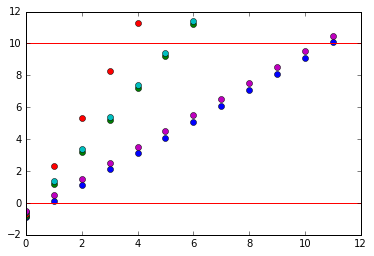

In [6]:
for traj in mytrajs:
    plt.plot([s.xyz[0][0] for s in traj], 'o')
    plt.plot([0.0]*13, 'r')
    plt.plot([10.0]*13, 'r')

Now we join the two trajectories together. The approach we use is a little complicated, but the basic idea is this:

1. We give a certain `shooting_point`: this is a frame from `prev_traj`
2. The `new_traj` finds the first snapshot for which `snapshot.xyz[0][0]` is on the other side of `shooting_point.xyz[0][0]`, where "other side" means "greater than" if `direction==1` or "less than" if `direction==-1`.

In [7]:
def join_as_shooting(prev_traj, new_traj, shooting_point, direction):
    sp_index = prev_traj.index(shooting_point)
    if direction == 1:
        prev_seg = prev_traj[:sp_index+1]
        new_seg = [snap for snap in new_traj if snap.xyz[0][0] > shooting_point.xyz[0][0]]
        result = prev_seg + new_seg
    elif direction == -1:
        prev_seg = prev_traj[sp_index:]
        new_seg = [snap for snap in new_traj if snap.xyz[0][0] < shooting_point.xyz[0][0]]
        result = new_seg + prev_seg
    else:
        raise RuntimeError("Bad direction")
    return paths.Trajectory(result)

In [8]:
# simple function to plot the traj and show where the snapshots originated
def simple_plot(traj, origin_trajs):
    plt.plot([s.xyz[0][0] for s in traj], 'k')
    for (otraj, style) in zip(origin_trajs, ['bo', 'go', 'ro', 'co', 'mo']):
        in_style = zip(*[(traj.index(s), s.xyz[0][0]) for s in traj if s in otraj])
        if len(in_style) == 2:
            plt.plot(in_style[0], in_style[1], style)

Note, importantly, that the trajectory we'll use as input for the piggybacker is the *whole* trajectory, not just the segment generated by one-way shooting.

In [9]:
# tuples of shooting point (frame number), direction, and acceptance
sp_index = [4, 4, 6, 5]
directions = [-1, +1, -1, -1]
acceptance = [True, True, False, True]
long_trials = mytrajs[1:]
sp_dir_acc_traj = zip(sp_index, directions, acceptance, long_trials)
#sp_dir_acc_traj = [(4, -1, True, traj2), (4, +1, True, traj3), (6, -1, False, traj4), (5, -1, True, traj5)]

In [10]:
inp_trajs = [traj1]
last_accepted = 0
for i in range(len(sp_dir_acc_traj)):
    move = sp_dir_acc_traj[i]
    prev_traj = inp_trajs[last_accepted]
    sp = move[0]
    direction = move[1]
    accept = move[2]
    long_trial = move[3]
    trial = join_as_shooting(prev_traj, long_trial, prev_traj[sp], direction)
    inp_trajs.append(trial)
    if accept:
        last_accepted = i+1

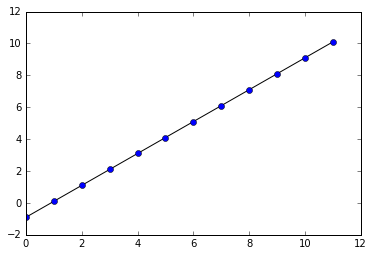

In [11]:
simple_plot(inp_trajs[0], mytrajs)

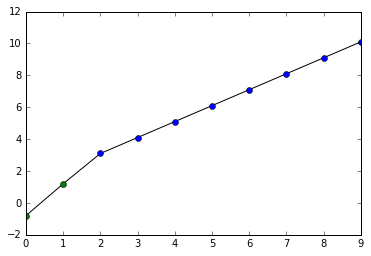

In [12]:
simple_plot(inp_trajs[1], mytrajs)

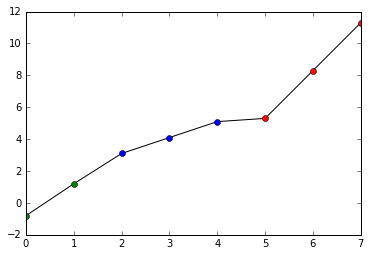

In [13]:
simple_plot(inp_trajs[2], mytrajs)

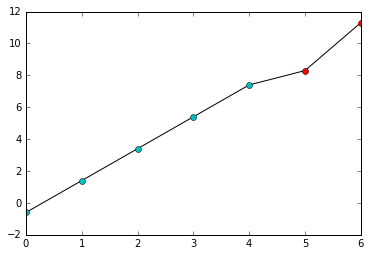

In [14]:
simple_plot(inp_trajs[3], mytrajs) # REJECTED PATH!

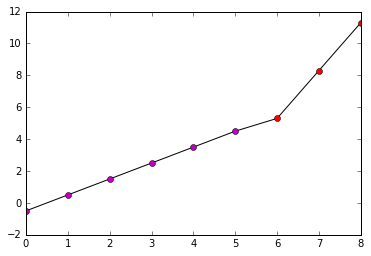

In [15]:
simple_plot(inp_trajs[4], mytrajs)

## OPS objects that must be created

This approach isn't quite as simple as a straightforward file converter, because you still need to create a few OPS objects (`Volume`s, `Ensemble`s, etc.) -- although you could, in principle, create other converters to automatically generate those.

Now we're going to create those objects.

In [16]:
# volumes
cv = paths.CV_Function("x", lambda snap: snap.xyz[0][0])
left_state = paths.CVRangeVolume(cv, float("-inf"), 0.0)
right_state = paths.CVRangeVolume(cv, 10.0, float("inf"))

In [17]:
# network
network = paths.TPSNetwork(left_state, right_state)
ensemble = network.sampling_ensembles[0]  # the only one

## Create the MoveStub and PseudoSimulator

Next we create the objects from OPSPiggybacker. Essentially, this boils down to creating something that can stub in for a move scheme in OPS, and feed back the results of the simulation.

In [18]:
initial_conditions = paths.SampleSet([
        paths.Sample(replica=0,
                     trajectory=inp_trajs[0],
                     ensemble=ensemble)
])
template = initial_conditions[0].trajectory[0]

In [19]:
shoot = oink.ShootingStub(ensemble)

In [20]:
sim = oink.ShootingPseudoSimulator(storage=paths.Storage('pseudoshoot.nc', 'w', template=template),
                                   initial_conditions=initial_conditions,
                                   mover=shoot,
                                   network=network)

## Feed the fake data to the PseudoSimulator

Now we actually run this to create our desired `.nc` file, which should be largely indistinguishable from one created by OPS! This is the primary "production" step of the process.

In [21]:
trial_trajectories = inp_trajs[1:]
replicas = [0]*len(sp_index)
move_inputs = zip(replicas, trial_trajectories, sp_index, acceptance)

In [22]:
for move in move_inputs:
    print move

(0, Trajectory[10], 4, True)
(0, Trajectory[8], 4, True)
(0, Trajectory[7], 6, False)
(0, Trajectory[9], 5, True)


In [23]:
sim.run(move_inputs)

In [24]:
#sim.storage.close()

## Use OPS analysis tools on the faked data

Finally, let's show that it works: we'll load that file and analyze it with the tools we would use for OPS.

In [25]:
#analysis_file = paths.AnalysisStorage("pseudoshoot.nc")
analysis_file = sim.storage

In [26]:
scheme = analysis_file.schemes[0]

In [27]:
step0 = analysis_file.steps[0]

In [28]:
scheme.move_summary(analysis_file)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 3/4 (75.00%)


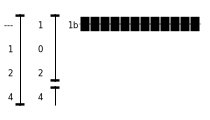

In [29]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG
history = ops_vis.ReplicaHistoryTree(
    storage=analysis_file,
    steps=analysis_file.steps[0:],
    replica=0
)

history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

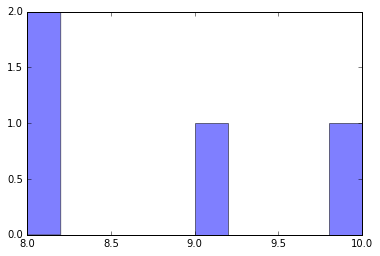

In [30]:
path_lengths = [len(step.active[0].trajectory) for step in analysis_file.steps]
plt.hist(path_lengths, alpha=0.5);

In [33]:
shoot.mimic.movers[0]